# Image Warping Lab

## Part 1: Interpolation

Since we are going to be warping images, we need to make sure we have a good interpolation function to deal with inexact pixel locations.

In the cell below, we scale an image by a factor of 2.30 in both x and y. The current setup uses a nearest neighbor approach. **Write a function called "interpolate" that performs bilateral interpolation.** This function should take in the image that is being interpolated, and the x and y point you are trying to approximate.

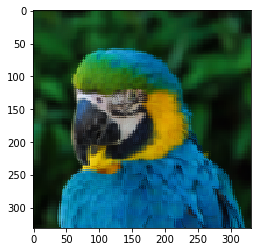

In [15]:
from scipy.ndimage import imread
import matplotlib.pyplot as plt
import numpy as np
from scipy.misc import imsave


def interpolate(image, x, y):

    #Get the four corners to interpolate between
    row = int(y)
    col = int(x)
    try:
        tl = image[row,col]
        tr = image[row,col+1]
        bl = image[row+1,col]
        br = image[row+1,col+1]
    except:
        return image[row,col]

    #Get the x and y difference
    dx = x % 1
    dy = y % 1
    
    #Interpolate the sides
    l = dy*tl + (1 - dy)*bl
    r = dy*tr + (1 - dy)*br
    
    #Interpolate to point
    return dx*l + (1-dx)*r


filename = "test.png"
im = imread(filename)

h,w,_ = im.shape

result = np.zeros((int(2.3*h),(int(2.3*w)),3), dtype="uint8")

result[0:h,0:w,:] = im

for i in range(len(result)):
    for j in range(len(result[0])):
        result[i,j] = interpolate(im, j/2.3, i/2.3)
        
plt.imshow(result,vmin=0)
plt.show()

## Part 2: Backwards Mapping

Now that we have a interpolation function, we need a function that performs a backward mapping between a source and target image.

Given a simple rotation transformation, **Write a function that performs a backwards mapping. This function should also call your interpolate function.**

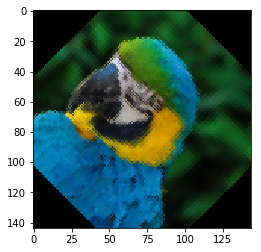

In [34]:
def backmap(im, transform):
    
    h,w,_ = im.shape
    
    result = np.zeros((h,w,3), dtype="uint8")
    
    invtransform = np.linalg.inv(transform)
    
    for i in range(h):
        for j in range(w):
            h_pt = np.matrix([[j],[i],[1]])
            c_pt = invtransform*h_pt
            x = c_pt[0]/c_pt[2]
            y = c_pt[1]/c_pt[2]

            if x < 0 or x >= w or y < 0 or y >= h:
                continue

            result[i,j]=interpolate(im,x,y)

    return result


from math import sin,cos,pi

filename = "test.png"
im = imread(filename)

transform = np.matrix([[cos(45 * pi/180), -sin(45 * pi/180), w/2],[sin(45 * pi/180),cos(45 * pi/180),-h/5],[0,0,1]])

result = backmap(im,transform)

plt.imshow(result,vmin=0)
plt.show()


## Part 3: Homographies

Now that we have the two specific functions that we need, let's start looking at some more interesting image warping. In class, we discussed how we can use homographies to warp images nonlinearly. In this lab, we have provided the homography generating code for you. 

**Combine your interpolation and backwards mapping code with our homography function to get a new image on the tv screen.** We also provide you with the pixel locations of the tv set.

In [ ]:
class Point():
    def __init__(self,x,y):
        self.x = x
        self.y = y


def getHomography(s0,s1,s2,s3,t0,t1,t2,t3):

    x0s = s0.x
    y0s = s0.y
    x0t = t0.x
    y0t = t0.y

    x1s = s1.x
    y1s = s1.y
    x1t = t1.x
    y1t = t1.y

    x2s = s2.x
    y2s = s2.y
    x2t = t2.x
    y2t = t2.y

    x3s = s3.x
    y3s = s3.y
    x3t = t3.x
    y3t = t3.y

    #Solve for the homography matrix
    A = np.matrix([
            [x0s, y0s, 1, 0, 0, 0, -x0t*x0s, -x0t*y0s],
            [0, 0, 0, x0s, y0s, 1, -y0t*x0s, -y0t*y0s],
            [x1s, y1s, 1, 0, 0, 0, -x1t*x1s, -x1t*y1s],
            [0, 0, 0, x1s, y1s, 1, -y1t*x1s, -y1t*y1s],
            [x2s, y2s, 1, 0, 0, 0, -x2t*x2s, -x2t*y2s],
            [0, 0, 0, x2s, y2s, 1, -y2t*x2s, -y2t*y2s],
            [x3s, y3s, 1, 0, 0, 0, -x3t*x3s, -x3t*y3s],
            [0, 0, 0, x3s, y3s, 1, -y3t*x3s, -y3t*y3s]
        ])

    b = np.matrix([
            [x0t],
            [y0t],
            [x1t],
            [y1t],
            [x2t],
            [y2t],
            [x3t],
            [y3t]
        ])

    #The homorgraphy solutions a-h
    solutions = np.linalg.solve(A,b)

    solutions = np.append(solutions,[[1.0]], axis=0)

    #Reshape the homography into the appropriate 3x3 matrix
    homography = np.reshape(solutions, (3,3))
    
    return homography

def getScreen():
    result = []
    screen = np.loadtxt("screen.txt")
    for line in screen:
        result.append(Point(int(line[0]), int(line[1])))
    return result

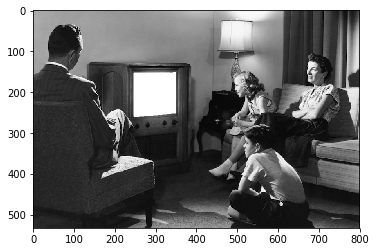

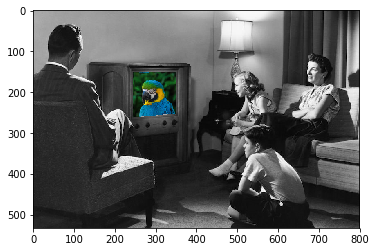

In [4]:


filename = "test.png"
im = imread(filename)

h,w,_ = im.shape
        
s0 = Point(0,0)
s1 = Point(w-1,0)
s2 = Point(w-1,h-1)
s3 = Point(0,h-1)

t0 = Point(245,152)
t1 = Point(349,150)
t2 = Point(349,253)
t3 = Point(246,261)

tv = imread('tv.jpg')
plt.imshow(tv,vmin=0)
plt.show()

homography = getHomography(s0,s1,s2,s3,t0,t1,t2,t3)
invHomography = np.linalg.inv(homography)

screen = getScreen()

for pt in screen:
    h_pt = np.matrix([[pt.x],[pt.y],[1]])
    c_pt = invHomography*h_pt
    x = c_pt[0]/c_pt[2]
    y = c_pt[1]/c_pt[2]
    
    tv[pt.y,pt.x]=interpolate(im,x,y)
    #tv[pt.y,pt.x]=im[int(y),int(x)]
    
imsave("Output.png", tv)
plt.imshow(tv,vmin=0)
plt.show()



## Part 4: Geometric Tests

We have a pretty robust warping algorithm now, but we need a way of determining which pixels are of interest and which pixels are not on our target image.

**Write pixel tester that makes a bounding box around the area of interest, then uses cross product geometric testing to verify if a pixel is on the canvas** (we acknowledge there are other ways you could solve this problem, but this is good practice).


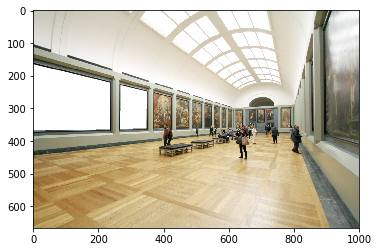

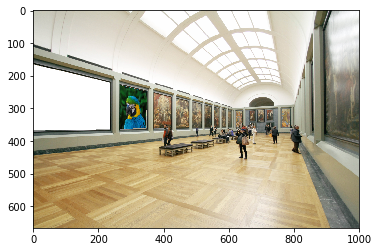

In [5]:
def getCanvas(t0, t1, t2, t3):
    canvas = []
    
    def isInside(x,y,t0, t1, t2, t3):
        #Get all side vectors
        vec0 = [t1.x - t0.x, t1.y - t0.y, 0]
        vec1 = [t2.x - t1.x, t2.y - t1.y, 0]
        vec2 = [t3.x - t2.x, t3.y - t2.y, 0]
        vec3 = [t0.x - t3.x, t0.y - t3.y, 0]
        
        #Get all vectors to the point
        com0 = [x - t0.x, y - t0.y, 0]
        com1 = [x - t1.x, y - t1.y, 0]
        com2 = [x - t2.x, y - t2.y, 0]
        com3 = [x - t3.x, y - t3.y, 0]
        
        #Perform all cross products and get the z components
        result = np.cross([vec0,vec1,vec2,vec3],[com0,com1,com2,com3])[:,2]
        
        #Check if all results point in the same direction
        if np.all(result > 0) or np.all(result < 0):
            return True
        
        else:
            return False
        
    
    #Make bounding box
    left = min(t0.x, t1.x, t2.x, t3.x)
    right = max(t0.x, t1.x, t2.x, t3.x)
    top = min(t0.y, t1.y, t2.y, t3.y)
    bottom = max(t0.y, t1.y, t2.y, t3.y)
    
    #Precise Bounding
    for i in range(left, right):
        for j in range(top, bottom):
            if isInside(i,j,t0,t1,t2,t3):
                canvas.append(Point(i,j))
    
    return canvas

museum = imread('museum.png')
plt.imshow(museum,vmin=0)
plt.show()

filename = "test.png"
im = imread(filename)

h,w,_ = im.shape
        
s0 = Point(0,0)
s1 = Point(w-3,0)
s2 = Point(w-3,h-3)
s3 = Point(0,h-3)

t0 = Point(268,230)
t1 = Point(349,249)
t2 = Point(347,361)
t3 = Point(267,363)

homography = getHomography(s0,s1,s2,s3,t0,t1,t2,t3)
invHomography = np.linalg.inv(homography)

canvas = getCanvas(t0,t1,t2,t3)

for pt in canvas:
    h_pt = np.matrix([[pt.x],[pt.y],[1]])
    c_pt = invHomography*h_pt
    x = c_pt[0]/c_pt[2]
    y = c_pt[1]/c_pt[2]
    
    museum[pt.y,pt.x]=interpolate(im,x,y)
    #museum[pt.y,pt.x]=im[int(y),int(x)]
    
imsave("Output.png", museum)
plt.imshow(museum,vmin=0)
plt.show()
